In [46]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

# Load and clean the data
file_path = '/kaggle/input/80000-steam-games-dataset/steam_data.csv'
steam_data = pd.read_csv(file_path)

In [47]:
# Parse price column
def parse_price_strict(price):
    if 'free' in str(price).lower():
        return 0.0
    match = re.search(r"\d+(\.\d+)?", str(price))
    return float(match.group()) if match else None

steam_data['price_parsed'] = steam_data['price'].apply(parse_price_strict)

# Parse score percentage
def parse_score_percentage(user_reviews):
    match = re.search(r"(\d{1,2})%", str(user_reviews))
    return int(match.group(1)) if match else None

steam_data['score_percentage'] = steam_data['user_reviews'].apply(parse_score_percentage)

# Parse categories
exception_categories = [
    'Co-op', 'Single-player', 'LAN', 'Controller Support', 'Online Multiplayer', 'Remote Play', 
    'Steam Workshop', 'Downloadable Content', 'Steam Cards', 'Trading Cards', 'VR', 'MMORPG', 
    'VR Support', 'PvE', 'PvP', 'Split Screen', 'Shared Screen', 'Split/Shared Screen', 
    'Cross Platform Play', 'Purchases'
]

def split_by_capitalized_letters(categories):
    if pd.isna(categories) or not isinstance(categories, str):
        return []
    matches = re.findall(r'(?:' + '|'.join(exception_categories) + r')|[A-Z][a-z]*', categories)
    return matches

steam_data['parsed_categories'] = steam_data['categories'].apply(split_by_capitalized_letters)

# Generate one-hot encoded categories
unique_categories = set(cat for categories in steam_data['parsed_categories'] for cat in categories)
category_dummies = pd.DataFrame(
    {f'category_{category}': steam_data['parsed_categories'].apply(lambda x: 1 if category in x else 0)
     for category in unique_categories}
)
steam_data = pd.concat([steam_data, category_dummies], axis=1)

# Group developers and publishers
developer_counts = steam_data['developer'].value_counts()
publisher_counts = steam_data['publisher'].value_counts()

steam_data['developer_grouped'] = steam_data['developer'].apply(
    lambda x: 'Known' if pd.notna(x) and developer_counts.get(x, 0) >= 10 else 'Unknown'
)
steam_data['publisher_grouped'] = steam_data['publisher'].apply(
    lambda x: 'Known' if pd.notna(x) and publisher_counts.get(x, 0) >= 20 else 'Unknown'
)

# One-hot encode developer and publisher groups
developer_dummies = pd.get_dummies(steam_data['developer_grouped'], prefix='developer', drop_first=True)
publisher_dummies = pd.get_dummies(steam_data['publisher_grouped'], prefix='publisher', drop_first=True)

# Drop rows with missing values in key columns
steam_data_cleaned = steam_data.dropna(subset=['price_parsed', 'score_percentage', 'categories', 'developer', 'publisher'])
steam_data_cleaned = pd.concat([steam_data_cleaned, developer_dummies, publisher_dummies], axis=1)

# Filter categories dynamically
category_columns = [f'category_{category}' for category in unique_categories if f'category_{category}' in steam_data_cleaned.columns]

In [48]:
# Combine features
X_parts = [
    steam_data_cleaned[['price_parsed'] + category_columns].to_numpy(),
    developer_dummies.to_numpy(),
    publisher_dummies.to_numpy()
]
X = np.hstack(X_parts)

# Ensure y is consistent
y = steam_data_cleaned['score_percentage'].to_numpy()

# Validate shapes
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

# Filter valid indices
valid_indices = ~np.isnan(y)
X = X[valid_indices]
y = y[valid_indices]

# Impute and scale
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=0)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Features shape: (81048, 4773), Target shape: (81048,)
Training set shape: X_train=(27664, 4773), y_train=(27664,)
Test set shape: X_test=(3074, 4773), y_test=(3074,)


In [49]:
rf = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=5, min_samples_leaf=4, min_samples_split=2)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

MSE: 592.78, R²: 0.03


In [50]:
xgb = XGBRegressor(random_state=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"MSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}")

MSE: 587.92, R²: 0.04


In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MSE: {mse_lr:.2f}, R²: {r2_lr:.2f}")

Linear Regression - MSE: 11120236888201046872075121197056.00, R²: -18223996684748614444855066624.00


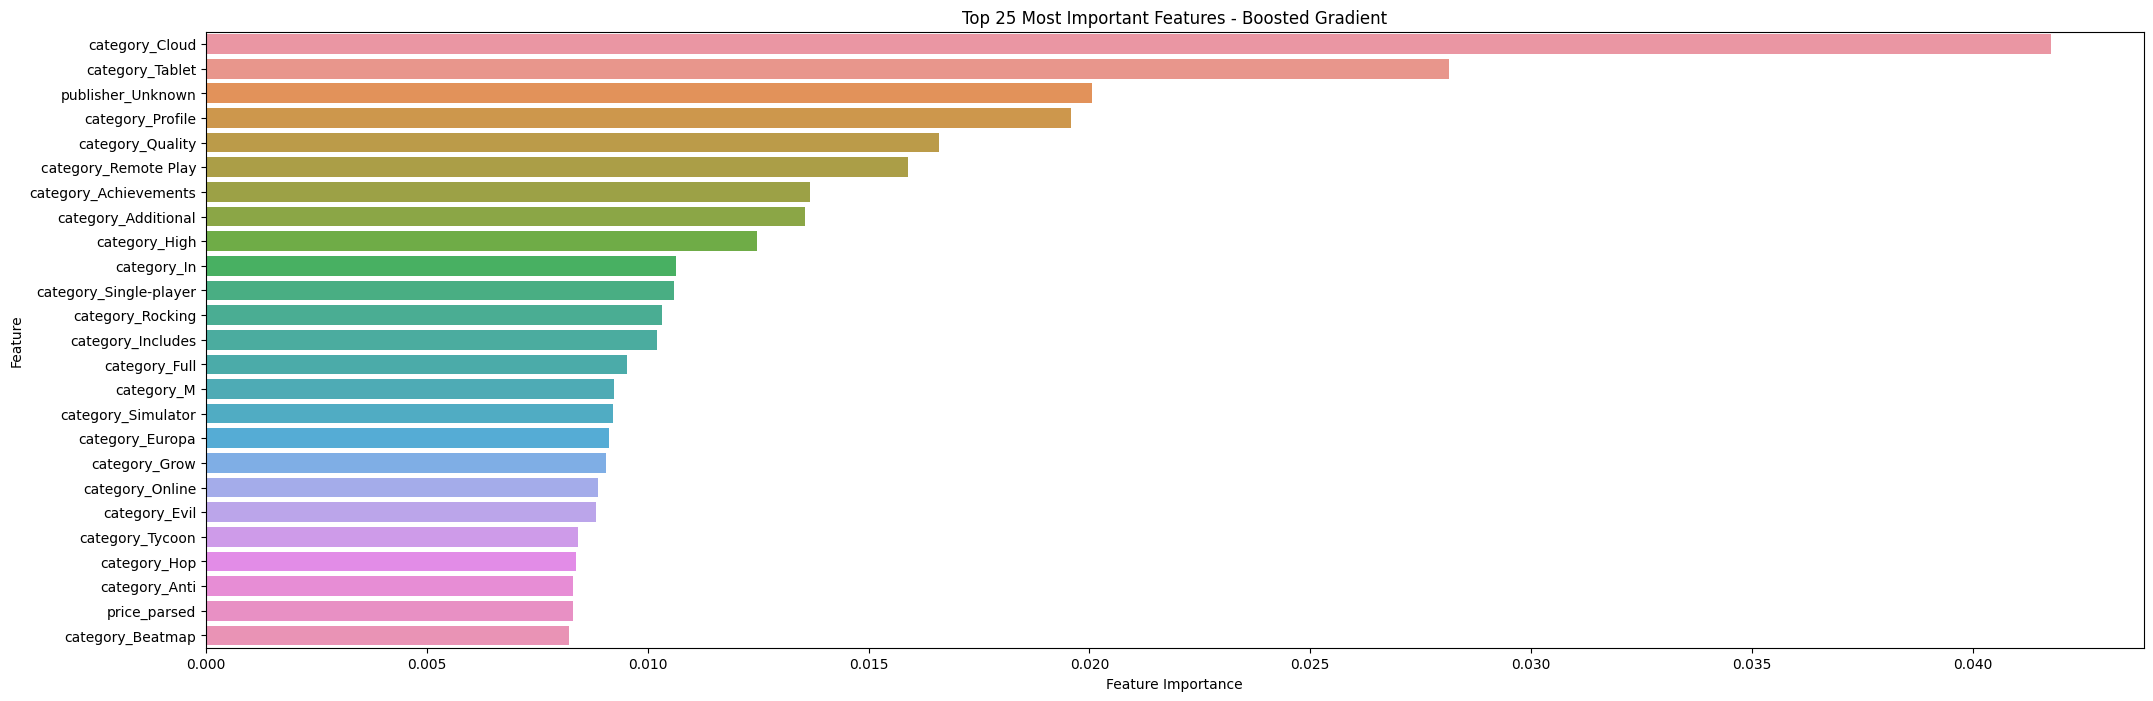

In [53]:
# Feature importance for Random Forest
feature_names = ['price_parsed'] + category_columns + list(developer_dummies.columns) + list(publisher_dummies.columns)
feature_importances_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(25, 8))
sns.barplot(data=feature_importances_xgb.head(25), x='Importance', y='Feature')
plt.title('Top 25 Most Important Features - Boosted Gradient')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

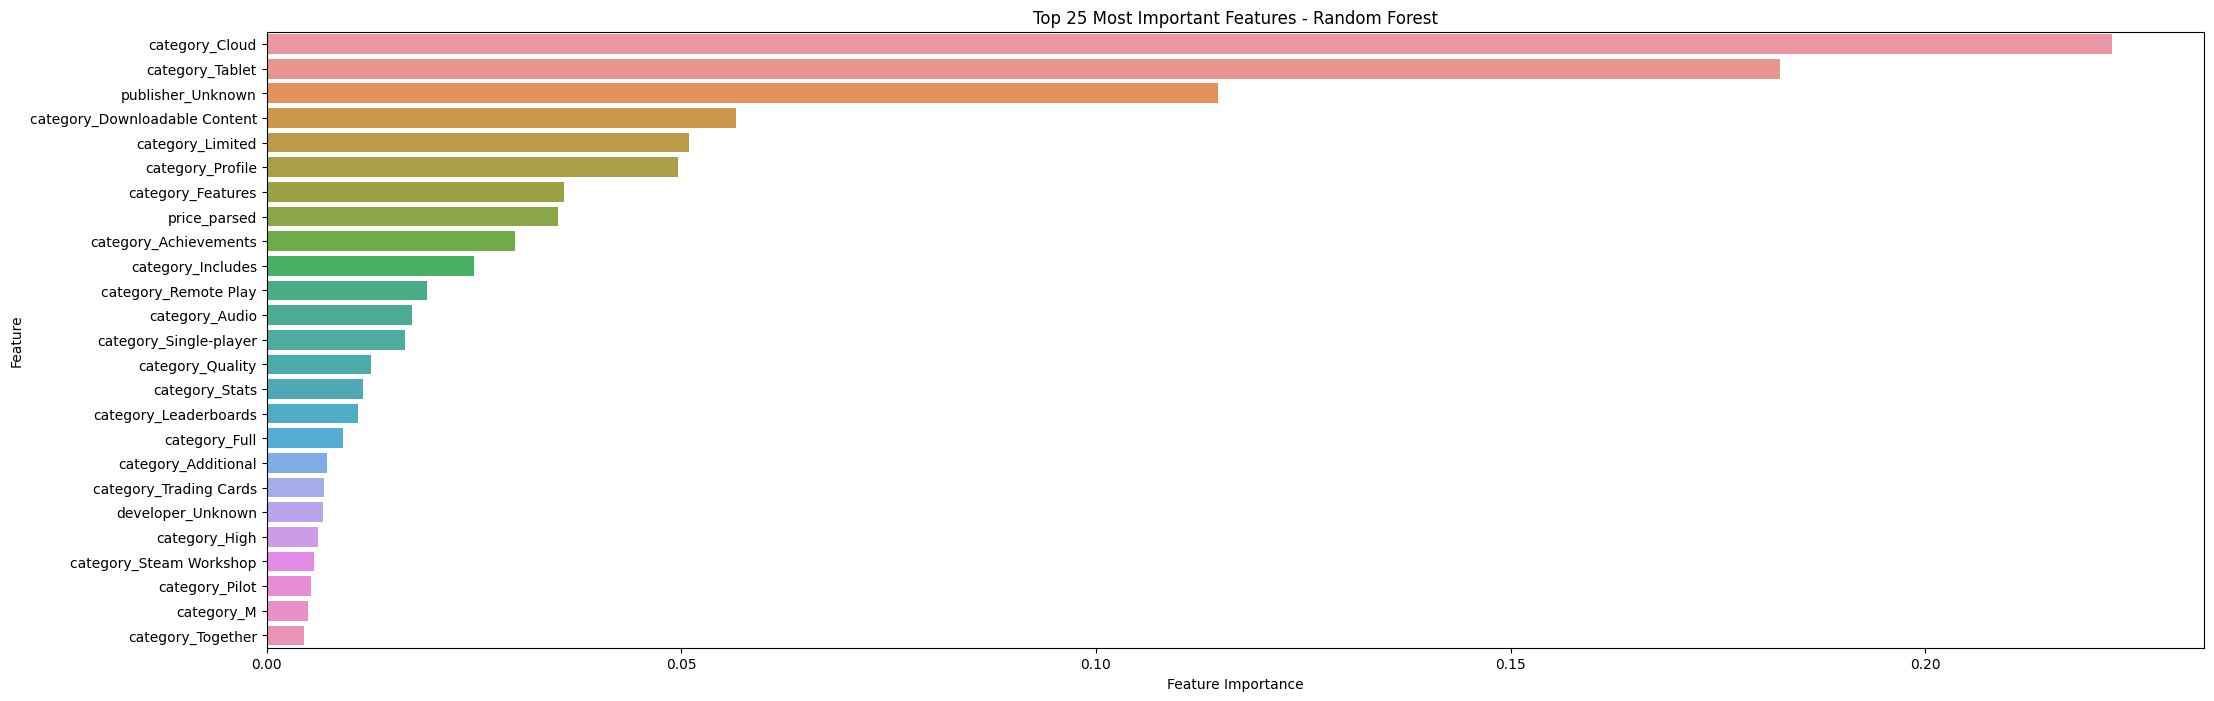

In [54]:
# Feature importance for Random Forest
feature_names = ['price_parsed'] + category_columns + list(developer_dummies.columns) + list(publisher_dummies.columns)
feature_importances_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(25, 8))
sns.barplot(data=feature_importances_rf.head(25), x='Importance', y='Feature')
plt.title('Top 25 Most Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()